In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#  read the names file
words = open('names.txt', 'r').read().splitlines()
words[0]

'emma'

In [ ]:
# build the vocabulary of chars and mapiings to/from integers
chars = sorted(list(set(''.join(words))))   # join all the words, remove duplicates using set(), turn it into a list to sort
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

In [380]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one? (hyperparameter)
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '---->', itos[ix])
    context = context[1:] + [ix]    # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


In [381]:
# build the dataset
def build_dataset(words):
  block_size = 3  # context length: how many characters do we take to predict the next one? (hyperparameter)
  X, Y = [], []
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix]    # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [382]:
len(words), n1

(32033, 25626)

In [344]:
# Look up table
C = torch.randn(size=(27, 2))

In [ ]:
emb = C[X]
emb.shape

In [ ]:
# hideen layer
W1 = torch.randn(size=(6, 100))  # 6 coz input is a 3x2 matrix flattened to 6, and 100 is a hyperparameter
b1 = torch.randn(100)

In [ ]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape

In [ ]:
h = emb.view(-1, 6) @ W1 + b1   # view is efficent, it doesnt create a new tensor with new storage
                                          # -1 coz pytorch figures out no.of input example

In [ ]:
h.shape

In [ ]:
# final layer
W2 = torch.randn(size=(100, 27))      # output is 27 coz 27 possible characters
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(dim=1, keepdim=True)

In [ ]:
prob[0].sum()

tensor(1.)

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()  # iterates the rows and each row grab column ix given by Y

In [ ]:
# ---------- More organized ----------- #
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [383]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(size=(27, 15), generator=g)
W1 = torch.randn(size=(45, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn(size=(300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [384]:
sum(p.nelement() for p in parameters)   # no.of parameters

22332

In [ ]:
emb = C[X]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
# counts = logits.exp()
# probs = counts / counts.sum(dim =1, keepdim=True)
# loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)   # cross_entropy is more efficient over our own implementation


Note :  why cross_entropy is more efficient ?
1. it doesnt create intermediate tensors in memory,
   instead pytorch will cluster up all these OPs into a fused kernels that efficiently evaluates the mathematical OPs
2. The backward pass can be made much more efficient, not just because its a fused kernel but mathematically its much simple backward pass.

    ex: in micrograd the forward to a tanh is a complex mathematical atomic OPs like exp(), mul(), div(), add()
    
    but when doing backward pass we dont have to do backward pass to these atomic OPs, instead we used 1-tan^2 x, makes it simplifies the derivatives
3. Makes things numerically well behaved. when doing exp() if the numbers grow negative and if there is high positive value it goes to INF
    ex: for logits = tensor([-100, -3, 0. 100])

    counts = logits.exp() gives

    tensor([3.2e-4, 4.99089e-02, 1.0000e+0,  inf])
4. Since large posiitve numbers causes problem, wehn we used Cross entropy pytorch internally subtracts an offset of max value in tensor.
    ex: logits = tensor([-100, -3, 0. 100]) - 100 # this -100 pytorch adds internally

In [387]:
for p in parameters:
  p.requires_grad = True

In [388]:
loss_l = []

In [389]:
for i in range(250000):

  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], size=(64,))

  # 1. forward pass
  emb = C[Xtr[ix]]      # grad the rows with index's ix
  h = torch.tanh(emb.view(-1, 45) @ W1 + b1)
  logits = h @ W2 + b2

  # 2. calculate loss
  loss = F.cross_entropy(logits, Ytr[ix])

  # 3. Grad zero
  for p in parameters:
    p.grad = None

  # 4. backward pass
  loss.backward()

  # 5. parameter update
  lr = 0.1 if i < 150000 else 0.01 # learning rate
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  loss_l.append(loss.item())

print(f"loss: {loss.log10().item()}")

loss: 0.2995041608810425


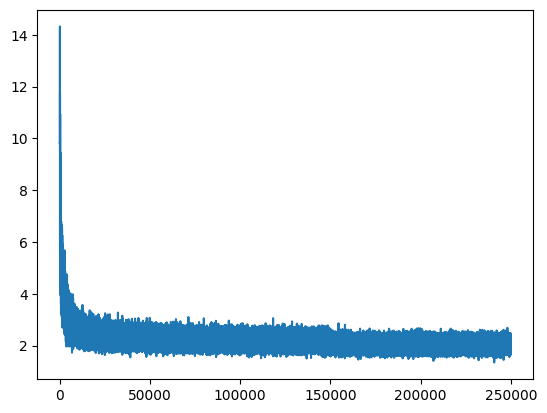

In [390]:
steps = [i for i in range(len(loss_l))]
plt.plot(steps[100:], loss_l[100:])

In [391]:
# eval for dev dataset
emb = C[Xdev]      # grad the rows with index's ix
h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2   #(32, 27)
dev_loss = F.cross_entropy(logits, Ydev)
dev_loss.item()

2.1390926837921143

In [392]:
# eval for train dataset
emb = C[Xtr]      # grad the rows with index's ix
h = torch.tanh(emb.view(-1, 45) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr)
train_loss.item()

2.024022102355957

In [ ]:
# train   80%          used to optimize the parameters of the model
# dev/validation  10%  used to optimize the hyper parameters
# test    10%          used to eval performance of the model

In [393]:
# Sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
  out = []
  context = [0] * block_size  # init with all ...
  while True:
    emb = C[torch.tensor(context)]  # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))


mora.
mayah.
see.
med.
ryla.
reisraj.
jd.
legradeek.
melin.
shy.
